In [323]:
# !pip install networkx

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.integrate import odeint
import numpy as np
from tqdm import tqdm

In [2]:
SEED = 2024

## Creating the network

In [3]:
A = sio.loadmat('./NuRsE/figure3/Figure3_produce/TECB.mat')['A']
A.shape

(1550, 1550)

In [4]:
# gene_reg_net=nx.from_numpy_matrix(A, create_using=nx.DiGraph,)

In [5]:
# pos = nx.spring_layout(gene_reg_net, seed=SEED)  # Seed for reproducible layout
# nx.draw(gene_reg_net, pos=pos)
# plt.show()

## Running the Dynamics

In [6]:
def michealis_menten_ODE(values, t, A, B=1, f=1, h=2):
        
    dvalues_dt = -B*np.power(values, f*np.ones(values.size)) + np.dot(A,values)

    return dvalues_dt

In [7]:
n_nodes = A.shape[0]
initial_values = np.ones(n_nodes) * 2
print(initial_values.shape)
t = np.arange(0, 4, 0.01)

values = odeint(michealis_menten_ODE, initial_values, t, args=(A,))

print(values.shape)


(1550,)
(400, 1550)


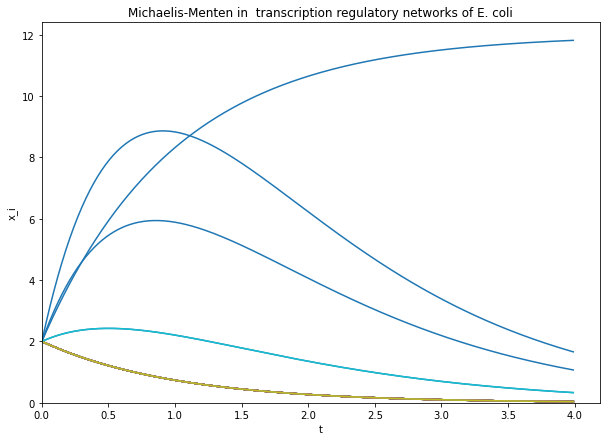

In [8]:
plt.figure(figsize=(10,7))

np.random.seed(SEED)
plot_nodes = np.random.choice(np.arange(n_nodes),50)

for i in plot_nodes:
    # print
    plt.plot(t, values[:,i])
plt.ylim(ymin=0)
plt.xlim(xmin=0)
plt.xlabel('t')
plt.ylabel('x_i')

plt.title('Michaelis-Menten in  transcription regulatory networks of E. coli')

plt.show()

## Removing nodes

In [9]:
def retained_nodes(n, prob_zero, seed=SEED):
    choices = [0, 1]
    
    probabilities = [prob_zero, 1 - prob_zero]
    np.random.seed(seed)
    ret = np.random.choice(choices, size=n, p=probabilities)
    
    return np.where(ret == 1)[0]
    
def get_activity_remnode(A,retained_nodes,h=0.01,tf=4):
    A_rows = A[retained_nodes]
    A_curr=A_rows[:,retained_nodes]

    t = np.arange(0, tf, h)
    initial_values = np.ones(retained_nodes.size) * 2

    values = odeint(michealis_menten_ODE, initial_values, t, args=(A_curr,))

    return np.mean(values[-1])


In [24]:
'''
cutoff  remove  iter    time
0.01    2%      228     ~1hr
0.01    10%     44      20min
'''

f_n_max = 1
f_rm = 0.1
nruns = 5

np.random.seed(SEED)
run_seed = np.random.choice(100, nruns, replace=False)

In [25]:
activities_nruns = []
cuttoff = 0.01
for seed in tqdm(run_seed):
    f_n = f_n_max
    activities = []
    
    while f_n > cuttoff:
        ret = retained_nodes(n_nodes,f_n,seed)
        # TODO: get GCC
        x_avg = get_activity_remnode(A,ret,tf=3)
        activities.append(x_avg)
        
        f_n -= f_n*f_rm 

    activities_nruns.append(activities)

  0%|          | 0/5 [00:00<?, ?it/s]

c:\Users\drshw\anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
c:\Users\drshw\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\drshw\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 5/5 [01:51<00:00, 22.37s/it]


In [28]:
activities_nruns = np.array(activities_nruns)
f_n = f_n_max
f_ns = []

while f_n > 0.01:
        f_ns.append(f_n) 
        f_n -= f_n*f_rm

print(len(f_ns))
print(activities_nruns.shape)

44
(5, 44)


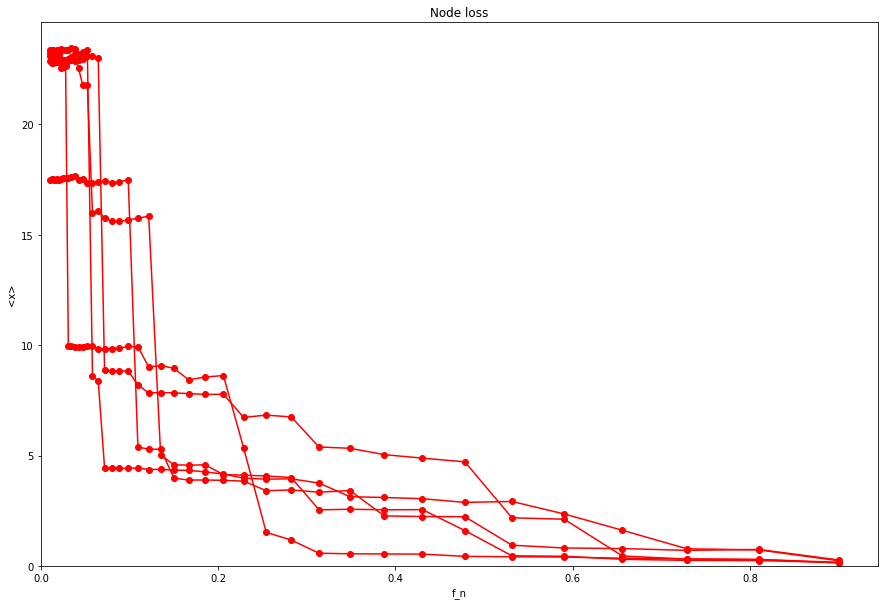

In [29]:
plt.figure(figsize=(15,10))
plt.plot(f_ns,activities_nruns.T, 'o-', color='r')

plt.ylim(ymin=0)
plt.xlim(xmin=0)
plt.xlabel(f'f_n')
plt.ylabel(f'<x>')
plt.title('Node loss')

plt.show()

In [ ]:
'''
TODO-
1. Use GCC to evaluate <x> everytime
2. Sequentially remove only 2% of the nodes
3. Run 50 simulations and plot all, and the average 
'''